In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import astropy.units as u


from toolkit import get_phoenix_model_spectrum, EchelleSpectrum

standard_path = ('/Users/bmmorris/data/Q3UW04/UT160706/'
                 'BD28_4211.0034.wfrmcpc.fits')
standard_spectrum = EchelleSpectrum.from_fits(standard_path)
target_path = glob('/Users/bmmorris/data/Q1UW09/UT170317/HD266611*wfrmcpc.fits')[0]
target_spectrum = EchelleSpectrum.from_fits(target_path)

def nearest_order(wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in target_spectrum.spectrum_list])

# nearest_order_7055 = nearest_order(7055*u.Angstrom)
# nearest_order_8860 = nearest_order(8860*u.Angstrom)

only_orders = list(range(len(target_spectrum.spectrum_list)))
target_spectrum.continuum_normalize(standard_spectrum,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

rv_shifts = u.Quantity([target_spectrum.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)

target_spectrum.offset_wavelength_solution(median_rv_shift)

In [2]:
from toolkit import ModelGrid, bands_TiO
model_grid = ModelGrid()

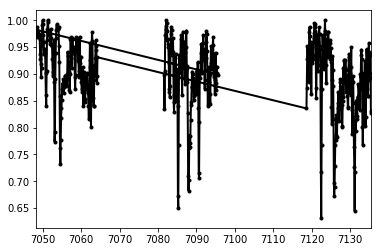

In [3]:
from toolkit import slice_spectrum, concatenate_spectra

spec_band = []
for band in bands_TiO:
    band_order = target_spectrum.get_order(nearest_order(band.core))
    target_slice = slice_spectrum(band_order, band.min-5*u.Angstrom, band.max+5*u.Angstrom)
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

slices = concatenate_spectra(spec_band)
slices.plot(normed=False, color='k', lw=2, marker='.')

In [4]:
from itertools import combinations
# Limit combinations such that delta T < 2000 K
temp_combinations = [i for i in combinations(model_grid.test_temps, 2) 
                     if abs(i[0] - i[1]) <= 2000]
n_combinations = len(temp_combinations)
n_fit_params = 4
best_parameters = np.zeros((n_combinations, n_fit_params))

In [5]:
from toolkit import instr_model
from scipy.optimize import fmin_l_bfgs_b
from astropy.utils.console import ProgressBar

def chi2(p, temp_phot, temp_spot):
    spotted_area, lam_offset, res = p
    model, residuals = instr_model(temp_phot, temp_spot, spotted_area, 
                                   lam_offset, res, slices, model_grid)
    return residuals

bounds = [[0, 0.5], [-1, 1], [1, 10]]
initp = [0.6, 2, 9]

# with ProgressBar(n_combinations, ipython_widget=True) as bar:
#     for i in range(n_combinations):
#         bar.update()
#         temp_spot, temp_phot = temp_combinations[i]
#         result = fmin_l_bfgs_b(chi2, initp, approx_grad=True, 
#                                bounds=bounds, args=(temp_phot, temp_spot))
#         best_parameters[i, :] = np.concatenate([result[0], result[1]])

In [6]:
# chi2s = []

# for i in range(n_combinations):
#     temp_spot, temp_phot = temp_combinations[i]
#     spotted_area, lam_offset, res = best_parameters[i, :]
#     model, residuals = instr_model(temp_phot, temp_spot, spotted_area, 
#                                    lam_offset, res, slices, model_grid)
#     chi2s.append(residuals)
# chi2s = np.array([i[0] for i in chi2s])
# best_params = np.hstack([best_parameters, np.atleast_2d(chi2s).T])

In [7]:
best_params_path = 'data/best_params.npy'

# np.save(best_params_path, best_parameters)
best_parameters = np.load(best_params_path)

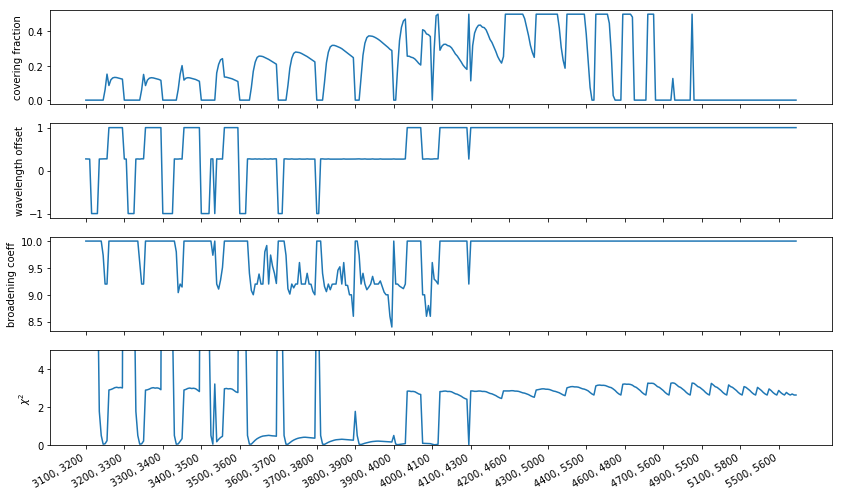

In [8]:
fig, ax = plt.subplots(n_fit_params, 1, figsize=(14, 8), sharex=True)
for i in range(n_fit_params):
    ax[i].plot(best_parameters[:, i]);

xticks = np.arange(0, n_combinations, 20)

ax[-1].set_xticks(xticks)
xticklabels = [', '.join(map(str, x)) for x in np.array(temp_combinations)[xticks, :]]
ax[-1].set_xticklabels(xticklabels)
ax[-1].set_ylim([0, 5])

for l in ax[-1].get_xticklabels():
    l.set_rotation(30)
    l.set_ha('right')

ax[0].set_ylabel('covering fraction')
ax[1].set_ylabel('wavelength offset')
ax[2].set_ylabel('broadening coeff')
ax[3].set_ylabel('$\chi^2$')

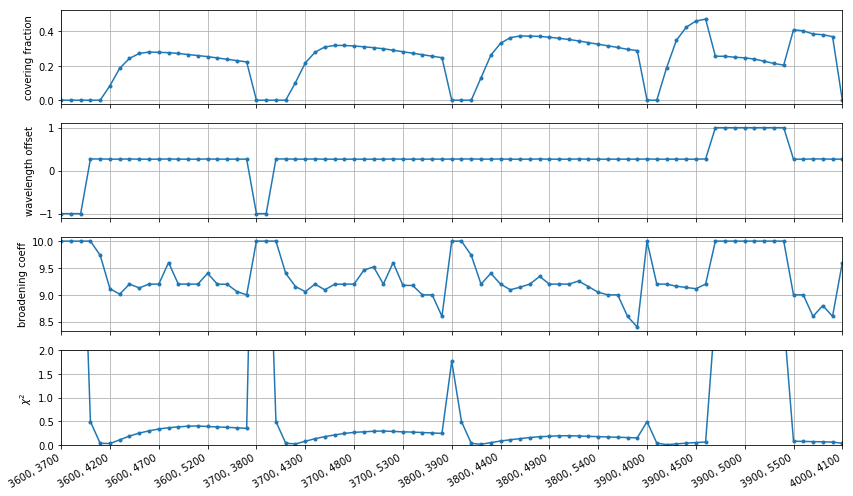

In [9]:
fig, ax = plt.subplots(n_fit_params, 1, figsize=(14, 8), sharex=True)
for i in range(n_fit_params):
    ax[i].plot(best_parameters[:, i], '.-');

xticks = np.arange(0, n_combinations, 5)

ax[-1].set_xticks(xticks)
xticklabels = [', '.join(map(str, x)) for x in np.array(temp_combinations)[xticks, :]]
ax[-1].set_xticklabels(xticklabels)
ax[-1].set_ylim([0, 2])
ax[-1].set_xlim([100, 180])
ax[3].set_ylabel('$\chi^2$')
for l in ax[-1].get_xticklabels():
    l.set_rotation(30)
    l.set_ha('right')

ax[0].set_ylabel('covering fraction')
ax[1].set_ylabel('wavelength offset')
ax[2].set_ylabel('broadening coeff')

# ax[1].set_ylim([0.26, 0.28])

for axis in ax:
    axis.grid()

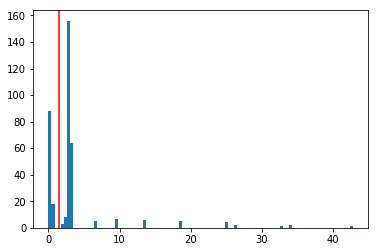

In [10]:
# from skimage.filters import threshold_isodata
# thresh = threshold_isodata(best_parameters[:, 3])
thresh = 1.5
good_fits = best_parameters[:, 3] < thresh

plt.hist(best_parameters[:, 3], 100);
plt.axvline(thresh, color='r')

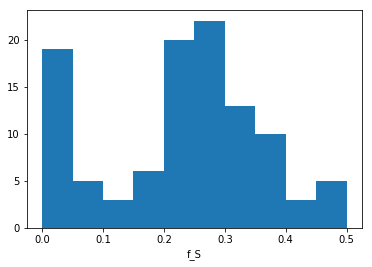

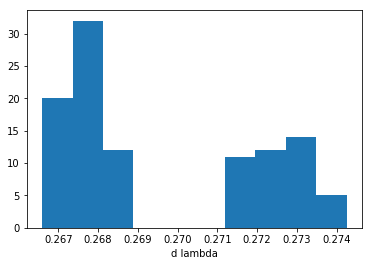

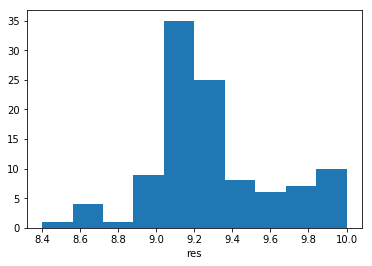

In [11]:
good_temps = np.array(temp_combinations)[good_fits, :]

fix_resolution = np.median(best_parameters[good_fits, 2])
fix_delta_lam = np.median(best_parameters[good_fits, 1])

temp_phot = np.max(good_temps, axis=1)
delta_temp = np.diff(good_temps, axis=1)[:, 0]

param_labels = ['f_S', 'd lambda', 'res']
for i, label in enumerate(param_labels):
    plt.figure()
    plt.hist(best_parameters[good_fits, i], 10)
    plt.xlabel(label)

Determine parameter priors based on least squares fits:

In [12]:
def random_in_range(min, max):
    return (max-min)*np.random.rand(1)[0] + min

def lnprior(theta):
    temp_phot, delta_temp, spotted_area = theta
    if ((3000 <= temp_phot <= 6200) and (0 <= delta_temp <= 2000) and 
        (0 <= spotted_area <= 0.5)):
        return 0.0
    return -np.inf

def lnlike(theta, model_grid, observed_spectrum):
    temp_phot, delta_temp, spotted_area = theta
    temp_spot = temp_phot - delta_temp
    model, residuals = instr_model(temp_phot, temp_spot, spotted_area, fix_delta_lam, 
                                   fix_resolution, observed_spectrum, model_grid)
    return -0.5*residuals#[0] #-0.5*np.sum((y-model)**2/yerr**2)

def lnprob(theta, model_grid, observed_spectrum):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model_grid, observed_spectrum)

from emcee import EnsembleSampler

initp = np.array([4400, 500, 0.3])
ndim, nwalkers = len(initp), 10 #2*len(initp)

pos = []

indices = np.arange(np.count_nonzero(good_fits))
np.random.shuffle(indices)

counter = -1
while len(pos) < nwalkers:
    counter += 1
    index = indices[counter]

    realization = [temp_phot[index], delta_temp[index], 
                   best_parameters[good_fits, 0][index]]
    if np.isfinite(lnprior(realization)):
        pos.append(realization)

sampler = EnsembleSampler(nwalkers, ndim, lnprob, threads=4,
                          args=(model_grid, slices))

In [13]:
n_steps = 50*nwalkers
sampler.run_mcmc(pos, n_steps);

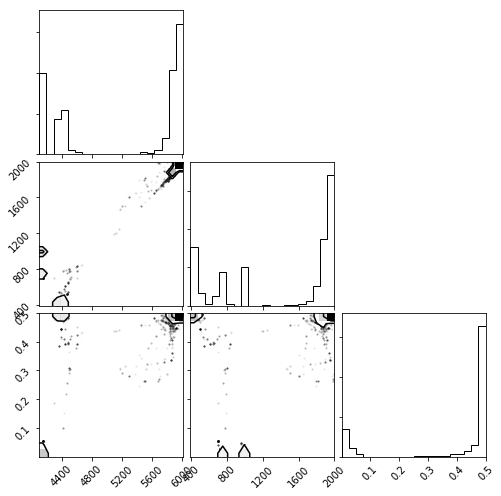

In [14]:
from corner import corner
corner(sampler.flatchain)
plt.show()

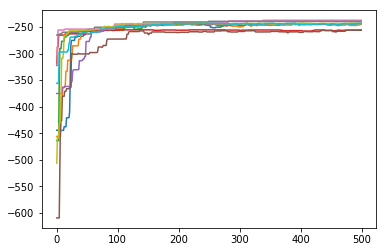

In [15]:
plt.plot(sampler.lnprobability.T);

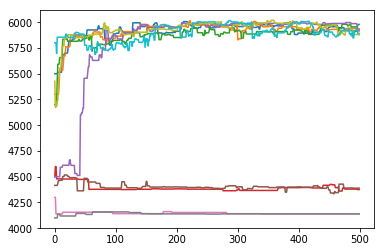

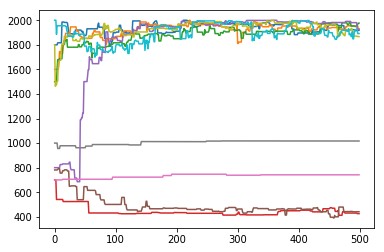

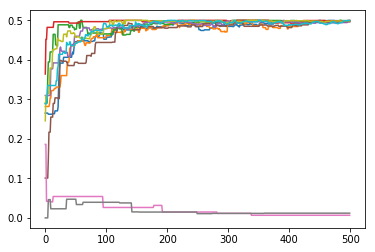

In [16]:
for i in range(sampler.chain.shape[-1]):
    plt.figure()
    plt.plot(sampler.chain[..., i].T)

In [17]:
best_step = sampler.flatchain[np.argmax(sampler.flatlnprobability)]

temp_phot = best_step[0]
temp_spot = best_step[0] - best_step[1]
model, resid = instr_model(temp_phot, temp_spot, best_step[2], fix_delta_lam, 
                           fix_resolution, slices, model_grid)

[ 474.77405839]


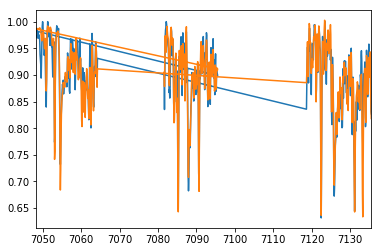

In [18]:
slices.plot()
print(resid)
plt.plot(slices.wavelength, model)# - slices.flux)

In [31]:
for species in lines:
    print(lines[species])

[7121.1697, 7123.8696, 7130.5399]


In [132]:
paths = ['/Users/bmmorris/tmp/BrettMorris.016632.txt',
         '/Users/bmmorris/tmp/BrettMorris.016631.txt', 
         '/Users/bmmorris/tmp/BrettMorris.016629.txt',]

nth = 10

vald3_wavelengths = []
vald3_names = []

for path in paths:
    lines = open(path).read().splitlines()

    def to_float(x):
        try: 
            return float(x)
        except ValueError:
            return np.nan

    rows = []
    for i in range(2, len(lines)-2):
        split_line = lines[i].split(',')
        row = [val.strip() for val in split_line[:3]]
        if len(row) == 3:
            rows.append(row)

    wavelengths = np.array([to_float(row[1]) for row in rows])
    strengths = np.array([to_float(row[2]) for row in rows])
    names = np.array([row[0][1:-1] for row in rows])
    nth_strength = np.sort(strengths[np.isfinite(strengths)])[-nth]
    strongest = strengths > nth_strength
    
    vald3_wavelengths.append(wavelengths[strongest])
    vald3_names.append(names[strongest])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater


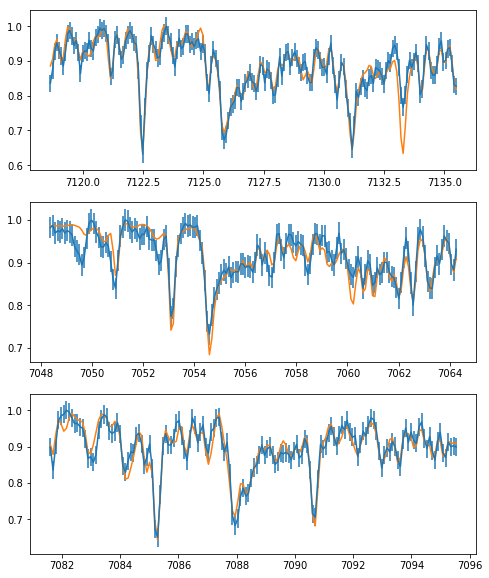

In [134]:
def plot_line(axis, species, wavelength, offset):
    yoffset = 0 if offset % 2 == 0 else 0.05
    axis.axvline(wavelength, ls=':', alpha=0.5)
    axis.annotate(species, xy=(wavelength, 1.0-yoffset), 
                  ha='left', va='bottom', 
                  rotation=40)

def plot_spliced_spectrum(observed_spectrum, model_flux, plot_lines=False):
    n_chunks = len(slices.wavelength_splits)
    fig, ax = plt.subplots(n_chunks, 1, figsize=(8, 10))

    for i, inds in enumerate(observed_spectrum.wavelength_splits):
        min_ind, max_ind = inds
#         ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
#                    observed_spectrum.flux[min_ind:max_ind])

        ax[i].errorbar(observed_spectrum.wavelength[min_ind:max_ind].value, 
                       observed_spectrum.flux[min_ind:max_ind], 
                       0.025*np.ones(max_ind-min_ind))
        ax[i].plot(observed_spectrum.wavelength[min_ind:max_ind], 
                   model_flux[min_ind:max_ind])
        
        if plot_lines:
            for j, name, wave in zip(range(len(vald3_names[i])), 
                                     vald3_names[i], 
                                     vald3_wavelengths[i]):
                plot_line(ax[i], name, wave, j)

    return fig, ax

fig, ax = plot_spliced_spectrum(slices, model)
# lines = {"CsII": [7121.1697, 7123.8696, 7130.5399], 
#          "FeII": [7134.5425, 7128.0876],
#          "FI": [7127.89]} 